<a href="https://colab.research.google.com/github/caccioppoli/etas_optimization/blob/main/etas_op.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing libraries

In [26]:
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from scipy.optimize import curve_fit
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading instrumental catalog

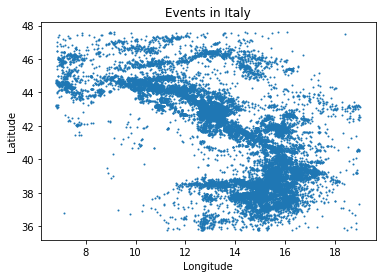

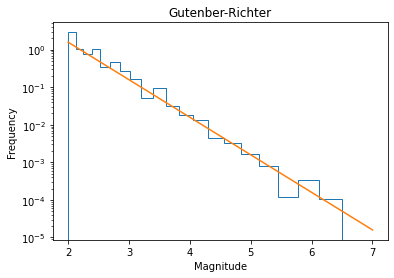

In [50]:
with open("drive/MyDrive/Colab Notebooks/cat_italia2.txt","r") as infile, open("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",'w') as outfile:
    for line in infile:
      outfile.write(" ".join(line.split()).replace('|',' '))
      outfile.write("\n")

# converto e memorizzo in secondi la data 

sdate = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="str",delimiter=" ",usecols=(1))
startdate = datetime.strptime('1985-01-02T18:39:30.740000',"%Y-%m-%dT%H:%M:%S.%f")
seconds = []
for time in sdate:
  date = datetime.strptime(time,"%Y-%m-%dT%H:%M:%S.%f")
  temp = (date - startdate).total_seconds()
  seconds.append(temp)

# converto e memorizzo le altre grandezze del catalogo

latitude = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="float",delimiter=" ",usecols=(2))
longitude = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="float",delimiter=" ",usecols=(3))
depth = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="float",delimiter=" ",usecols=(4))
magnitude = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="float",delimiter=" ",usecols=(10))

####### PLOTTING #########

# plotting events
plt.scatter(longitude,latitude,s=1,label='Events in Italy')
plt.title('Events in Italy')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# plotting GR

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins,histtype='step',density=True, label='GR distribution')
  plt.yscale('log')
  plt.title('Gutenber-Richter')
  plt.xlabel('Magnitude')
  plt.ylabel('Frequency')

plot_loghist(magnitude, 20)

# plotting b=1 function

xx = np.linspace(2, 7, num=100)
px = np.power(10,2.2)*np.power(10,-1*xx) 
plt.plot(xx,px,label='b=1')
plt.show()




#Defining functions

In [ ]:
# Calculate the great circle distance in kilometers between two points on the earth (specified in decimal degrees)

def distance(s_lat, e_lat, s_lng, e_lng):
  # approximate radius of earth in km
  R = 6373.0
  s_lat = s_lat*np.pi/180.0                      
  s_lng = np.deg2rad(s_lng)     
  e_lat = np.deg2rad(e_lat)                       
  e_lng = np.deg2rad(e_lng)  
  d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
  return 2 * R * np.arcsin(np.sqrt(d))

#Declustering Space-Time Window - Instrumental catalog



In [ ]:
lencat = len(seconds)
print('catalog length:',lencat,'events')
for magnitude_threshold in range(4,7):
  filemain = open("drive/MyDrive/Colab Notebooks/main_exp_stw_%s.txt" %magnitude_threshold, "w")
  fileafter = open("drive/MyDrive/Colab Notebooks/after_exp_stw_%s.txt" %magnitude_threshold, "w")
  filefore = open("drive/MyDrive/Colab Notebooks/fore_exp_stw_%s.txt" %magnitude_threshold, "w")

  ####  DEFINING PARAMETERS ####

  time_limit_fore = 7*24*3600 #within 7 days before
  time_limit_after = 3*24*3600 #within 3 days after
  space_limit = 100 #within 100 km

  ##############################

  #### DEFINING ARRAY #####

  threshold_after = np.zeros(4)
  threshold_after[0] = 2.5
  threshold_after[1] = 3
  threshold_after[2] = 3.5
  threshold_after[3] = 4

  threshold_time = np.zeros(3)
  threshold_time[0] = 1*24*3600
  threshold_time[1] = 3*24*3600
  threshold_time[2] = 10*24*3600

  threshold_space = np.zeros(5)
  threshold_space[0] = 3
  threshold_space[1] = 10
  threshold_space[2] = 20
  threshold_space[3] = 40

  #########################

  #### SEARCHING FOR MAINSHOCKS ####

  for event in range(1,lencat):
    if(magnitude[event]>=magnitude_threshold and magnitude[event]<magnitude_threshold+1):
      for fore in range(event-1,-1,-1):     
        dt = seconds[event]-seconds[fore]
        if(dt>time_limit_fore):
          main_index = True
          break
        elif(dt<time_limit_fore and magnitude[fore]>=magnitude_threshold):
          dr = distance(latitude[event],latitude[fore],longitude[event],longitude[fore])
          if (dr>space_limit):
            main_index = True
            break
      for after in range(event+1,lencat): 
        dt = seconds[event]-seconds[after]
        if(dt>time_limit_after):
          main_index = True
          break
        elif(dt<time_limit_after and magnitude[after]>=magnitude_threshold):
          dr = distance(latitude[event],latitude[after],longitude[event],longitude[after])
          if (dr>space_limit):
            main_index = True
            break
        
      filemain.write(str(seconds[event])+" "+str(magnitude[event])+" "+str(latitude[event])+" "+str(longitude[event])+"\n")

  #################################

  #### BUILDING AFTERSHOCK & FORESHOCKS MATRIX ####
      
      if(main_index == True):

        nafter = np.zeros([4,3,5],dtype=np.int16)
        nfore = np.zeros([4,3,5],dtype=np.int16)
        
        threshold_space[4]=0.01*np.power(10,0.5*magnitude[event])

        for after in range(event+1,lencat): 
          dt = seconds[after]-seconds[event]
          dr = distance(latitude[event],latitude[after],longitude[event],longitude[after])
          for mag_aft in range(4):
            for time_aft in range(3):
              for space_aft in range(5):
                if(magnitude[after]>=threshold_after[mag_aft]):
                  if(dt<threshold_time[time_aft]):
                    if(dr<threshold_space[space_aft]):
                      nafter[mag_aft,time_aft,space_aft]+=1
                  
        for fore in range(event-1,-1,-1):  
          dt = seconds[event]-seconds[fore]
          dr = distance(latitude[event],latitude[fore],longitude[event],longitude[fore])
          for mag_aft in range(4):
            for time_aft in range(3):
              for space_aft in range(5):
                if(magnitude[fore]>=threshold_after[mag_aft]):
                  if(dt<threshold_time[time_aft]):
                    if(dr<threshold_space[space_aft]):
                      nfore[mag_aft,time_aft,space_aft]+=1
                    
  ###################################################

  #### WRITING AFTERSHOCK & FORESHOCKS MATRIX ####

        fileafter.write(str(nafter)+"\n")
        filefore.write(str(nfore)+"\n")

  ################################################

  filemain.close()
  fileafter.close()
  filefore.close()




catalog length: 51206 events


#Declustering Zaliapin/Baiesi - Instrumental catalog



In [ ]:
lencat = len(seconds)
print('catalog length:',lencat,'events')
filemain = open("drive/MyDrive/Colab Notebooks/mainshocks_exp_zb.txt", "w")
fileafter = open("drive/MyDrive/Colab Notebooks/aftershocks_exp_zb.txt", "w")
filefore = open("drive/MyDrive/Colab Notebooks/foreshocks_exp_zb.txt", "w")

####  DEFINING PARAMETERS ####

nc = 10^7 
df = 1.6
b = 1.05

##############################

#### DEFINING ARRAY #####

threshold_after = np.zeros(4)
threshold_after[0] = 2.5
threshold_after[1] = 3
threshold_after[2] = 3.5
threshold_after[3] = 4

threshold_time = np.zeros(3)
threshold_time[0] = 1*24*3600
threshold_time[1] = 3*24*3600
threshold_time[2] = 10*24*3600

threshold_space = np.zeros(5)
threshold_space[0] = 3
threshold_space[1] = 10
threshold_space[2] = 20
threshold_space[3] = 40

iflag = np.zeros(lencat)
itrigger = np.zeros(lencat)
invtrig = np.zeros(lencat)
nnafter = np.zeros(lencat)
father = np.zeros(lencat)
index = np.zeros([35000,35000])

#########################

for event in range(1,lencat):
  for previous in range(event-1,-1,-1):
    nij_min = np.power(10,12)
    dt = seconds[event]-seconds[previous]
    if(dt>3600*24*100):
      break
    dr = distance(latitude[event],latitude[previous],longitude[event],longitude[previous])*1000 #meters
    nij = (dt+0.1)*np.power(dr+0.1,df)*np.power(10,-b*magnitude[previous])
    if(nij < nij_min):
      nij_min = nij
      previous_min = previous
  if(nij_min < nc):
    father[event] = previous_min
    if(iflag[previous_min]==0):
      iflag[previous_min] = 1
      ntrigger = ntrigger + 1
      itrigger[ntrigger] = previous_min
      invtrig[previous_min] = ntrigger
    ntr = invtrig[previous_min]
    nnafter[ntr] += 1
    index[ntr,nnafter[ntr]] = event 
    #index: matrice con indice di riga il il numero (non l'indice) del sito che triggera, indice di colonna il numero dell'after 
    #cosi da poter capire l'indice del figlio (albero)
    #con itrigger[ntrigger] trovi il papà

prova = open("drive/MyDrive/Colab Notebooks/prova.txt", "w")
for i in range(lencat):
  prova.write(str[magnitude[i]]+" "+str[nnafter[invtrig[i]]]+"\n")







catalog length: 51206 events


KeyboardInterrupt: ignored